In [1]:
import pycwt as wavelet
from matplotlib import pyplot
import matplotlib.pylab as plt
from pycwt.helpers import find
import numpy as np
import pandas as pd
import datetime
import plotly as pt
import plotly.graph_objects as go
from plotly.offline import iplot
from scipy import signal
import pytz

In [2]:
df_60s = pd.read_pickle('../../../Data/2023_03_09_spiekeroog/Geolore/Total_data_untill_20230309.pkl')

In [3]:
wind = pd.read_csv('../../../Data/2023_03_27_norderney_weather_dwd/produkt_zehn_min_ff_20210923_20230326_03631.txt'
            , sep=';', parse_dates=[1])

perci = pd.read_csv('../../../Data/2023_03_27_norderney_weather_dwd/produkt_zehn_min_rr_20210923_20230326_03631.txt'
            , sep=';', parse_dates=[1])


solar = pd.read_csv('../../../Data/2023_03_27_norderney_weather_dwd/produkt_zehn_min_sd_20210923_20230326_03631.txt'
            , sep=';', parse_dates=[1])

temp = pd.read_csv('../../../Data/2023_03_27_norderney_weather_dwd/produkt_zehn_min_tu_20210923_20230326_03631.txt'
            , sep=';', parse_dates=[1])


In [4]:
data_merged = pd.merge(pd.merge(pd.merge(temp, perci), wind), solar)
data_merged['MESS_DATUM'] = pd.to_datetime(data_merged['MESS_DATUM'], utc = pytz.timezone("Europe/Berlin"))
data_merged

STATIONS_ID                MESS_DATUM    QN   PP_10  TT_10  TM5_10  \
0             3631 2021-09-23 00:00:00+00:00     3  1017.6   15.7    14.6   
1             3631 2021-09-23 00:10:00+00:00     3  1017.4   15.6    14.7   
2             3631 2021-09-23 00:20:00+00:00     3  1017.1   15.5    14.4   
3             3631 2021-09-23 00:30:00+00:00     3  1016.9   15.6    14.6   
4             3631 2021-09-23 00:40:00+00:00     3  1016.8   15.6    14.6   
...            ...                       ...   ...     ...    ...     ...   
79195         3631 2023-03-26 23:10:00+00:00     2  1009.7    5.6     4.4   
79196         3631 2023-03-26 23:20:00+00:00     2  1009.8    5.5     4.5   
79197         3631 2023-03-26 23:30:00+00:00     2  1009.9    5.5     4.4   
79198         3631 2023-03-26 23:40:00+00:00     2  1010.1    4.8     3.6   
79199         3631 2023-03-26 23:50:00+00:00     2  1010.3    4.8     3.6   

       RF_10  TD_10  eor  RWS_DAU_10  RWS_10  RWS_IND_10  FF_10  DD_10  DS_10  \
0       86.5   13.5  eor           0     0.0           0    7.0    220    0.0   
1       85.4   13.2  eor           0     0.0           0    7.4    220    0.0   
2       85.9   13.2  eor           0     0.0           0    7.2    220    0.0   
3       85.7   13.2  eor           0     0.0           0    7.3    220    0.0   
4       85.9   13.3  eor           0     0.0           0    7.3    220    0.0   
...      ...    ...  ...         ...     ...         ...    ...    ...    ...   
79195   62.9   -0.9  eor           0     0.0           0   10.7    340 -999.0   
79196   64.4   -0.7  eor           0     0.0           0   11.9    330 -999.0   
79197   63.5   -0.9  eor           0     0.0           0   12.7    330 -999.0   
79198   75.8    0.9  eor           0     0.0           0   11.4    350 -999.0   
79199   76.1    1.0  eor           0     0.0           0   10.1    340 -999.0   

       GS_10  SD_10  LS_10  
0        0.0    0.0   -999  
1        0.0    0.0   -999  
2        0.0    0.0   -999  
3        0.0    0.0   -999  
4        0.0    0.0   -999  
...      ...    ...    ...  
79195    0.0    0.0   -999  
79196    0.0    0.0   -999  
79197    0.0    0.0   -999  
79198    0.0    0.0   -999  
79199    0.0    0.0   -999  

[79200 rows x 18 columns]

In [5]:
custom_date_parser = lambda x: datetime.datetime.strptime(x, "%Y%m%d%H")


soil = pd.read_csv('../../../Data/2023_03_27_norderney_weather_dwd/bodentemp/produkt_eb_stunde_20211023_20230425_03631.txt'
            , sep=';', parse_dates=[1], date_parser=custom_date_parser)

soil['MESS_DATUM'] = pd.to_datetime(soil['MESS_DATUM'], utc = pytz.timezone("Europe/Berlin"))

### Wavelet Settings

From the following link

https://pycwt.readthedocs.io/en/latest/tutorial.html#time-series-spectral-analysis-using-wavelets

In [52]:
#-------------------------------------
start_date = datetime.datetime(2022,8,10, tzinfo = pytz.timezone("Europe/Berlin"))
end_date = datetime.datetime(2023,3,8, tzinfo = pytz.timezone("Europe/Berlin"))

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 10)

geolore_data_dated = df_60s[(df_60s.index>=start_date) &  (df_60s.index<=end_date)]
#--------------------------------------
dat = geolore_data_dated.iloc[:,2]
#--------------------------------------

dt = 1/60      # Sampling interval in hours
N = dat.size
t = np.arange(N)
dat_notrend = signal.detrend(dat)
std = np.std(dat_notrend)
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
alpha, _, _ = wavelet.ar1(dat_notrend)  # Lag-1 autocorrelation for red noise
mother = wavelet.Morlet(6)
s0 = 60* dt  # Starting scale, in this case 24 *  dt  = 1 hour
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj   # Seven powers of two with dj sub-octaves

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)


sel = find((period >= 20) & (period < 50))
# We also calculate the scale average between 20 hours and 28 hours, and its significance level.
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2141333167.py:5: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2141333167.py:6: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



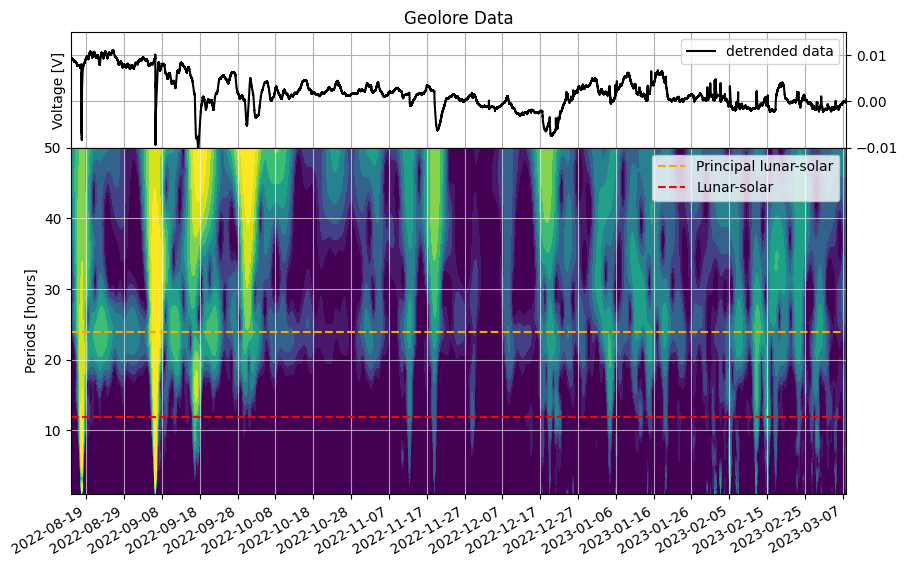

In [53]:
pyplot.close('all')
pyplot.ioff()

fig , axes = plt.subplots(2, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1,3]})

ax = axes[0]

ax.plot(geolore_data_dated.index, dat, 'k', linewidth=1.5, label='detrended data')
ax.set_ylim(-0.01, 0.015)
ax.legend()
ax.grid()
ax.yaxis.tick_right()
ax.set_ylabel("Voltage [V]")
ax.set_title("Geolore Data")

bx = axes[1]

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

bx.contourf(geolore_data_dated.index, period, np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
bx.set_ylim(1,50)
bx.set_xticks(days)
bx.set_xlim(np.datetime64('2022-08-15'))
bx.tick_params(axis ='x', labelrotation =30)
plt.xticks(ha='right')
bx.grid(color='white',alpha=0.6)
bx.set_ylabel("Periods [hours]")

bx.hlines(23.934, days[0], days[-1], color='orange', linestyles='dashed', label='Principal lunar-solar')
bx.hlines(11.967, days[0], days[-1], color='red', linestyles='dashed',    label='Lunar-solar')
bx.legend()
plt.show()

#fig.savefig("Output/Wavelet_SP_geolore.pdf", dpi=300)
fig.savefig("Output/Wavelet_SP_geolore.png", dpi=300)

In [54]:
#-------------------------------------
start_date = datetime.datetime(2022,8,10, tzinfo = pytz.timezone("Europe/Berlin"))
end_date = datetime.datetime(2023,3,8, tzinfo = pytz.timezone("Europe/Berlin"))

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 10)

weather_data_dated = data_merged[(data_merged["MESS_DATUM"]>=start_date) &  (data_merged["MESS_DATUM"]<=end_date)]
#--------------------------------------
dat = weather_data_dated["PP_10"].values
#--------------------------------------


dt = 10/60      # Sampling interval in hours
N = dat.size
t = np.arange(N)
dat_notrend = signal.detrend(dat)
std = np.std(dat_notrend)
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
#alpha, _, _ = wavelet.ar1(dat_notrend)  # Lag-1 autocorrelation for red noise
mother = wavelet.Morlet(6)
s0 = 6 * dt  # Starting scale, in this case 6 *  dt  = 1 hour
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj   # Seven powers of two with dj sub-octaves

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power /= scales[:, None]
#signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
#                                         significance_level=0.95,
#                                         wavelet=mother)
#sig95 = np.ones([1, N]) * signif[:, None]
#sig95 = power / sig95

#glbl_power = power.mean(axis=1)
#dof = N - scales  # Correction for padding at edges
#glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                        significance_level=0.95, dof=dof,
#                                        wavelet=mother)


#sel = find((period >= 20) & (period < 50))
# We also calculate the scale average between 20 hours and 28 hours, and its significance level.
#Cdelta = mother.cdelta
#scale_avg = (scales * np.ones((N, 1))).transpose()
#scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
#scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
#scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
#                                             significance_level=0.95,
#                                             dof=[scales[sel[0]],
#                                                  scales[sel[-1]]],
#                                             wavelet=mother)

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2045096975.py:5: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2045096975.py:6: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



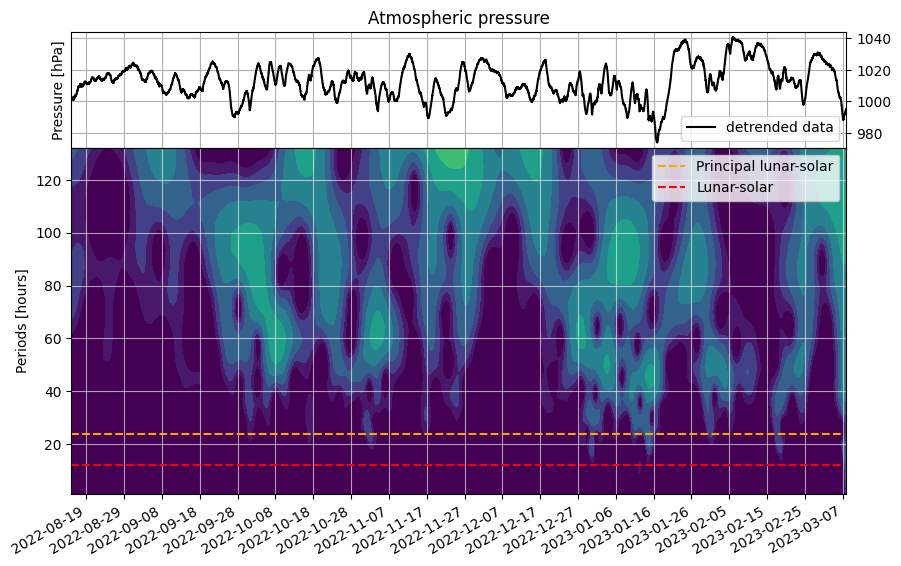

In [55]:
pyplot.close('all')
pyplot.ioff()

fig , axes = plt.subplots(2, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1,3]})

ax = axes[0]

ax.plot(weather_data_dated["MESS_DATUM"], dat, 'k', linewidth=1.5, label='detrended data')
#ax.set_ylim(-0.01, 0.015)
ax.legend()
ax.grid()
ax.yaxis.tick_right()
ax.set_ylabel("Pressure [hPa]")
ax.set_title("Atmospheric pressure")

bx = axes[1]

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

bx.contourf(weather_data_dated["MESS_DATUM"], period, np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
#bx.set_ylim(1,100)
bx.set_xticks(days)
bx.set_xlim(np.datetime64('2022-08-15'))
bx.tick_params(axis ='x', labelrotation =30)
plt.xticks(ha='right')
bx.grid(color='white',alpha=0.6)
bx.set_ylabel("Periods [hours]")

bx.hlines(23.934, days[0], days[-1], color='orange', linestyles='dashed', label='Principal lunar-solar')
bx.hlines(11.967, days[0], days[-1], color='red', linestyles='dashed',    label='Lunar-solar')
bx.legend()
plt.show()

#fig.savefig("Output/Wavelet_weather_atmpressure.pdf", dpi=300)
fig.savefig("Output/Wavelet_weather_atmpressure.png", dpi=300)

In [56]:
#-------------------------------------
start_date = datetime.datetime(2022,8,10, tzinfo = pytz.timezone("Europe/Berlin"))
end_date = datetime.datetime(2023,3,8, tzinfo = pytz.timezone("Europe/Berlin"))

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 10)

weather_data_dated = data_merged[(data_merged["MESS_DATUM"]>=start_date) &  (data_merged["MESS_DATUM"]<=end_date)]
#--------------------------------------
dat = weather_data_dated["TT_10"].values
#--------------------------------------

dt = 10/60      # Sampling interval in hours
N = dat.size
t = np.arange(N)
dat_notrend = signal.detrend(dat)
std = np.std(dat_notrend)
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
#alpha, _, _ = wavelet.ar1(dat_notrend)  # Lag-1 autocorrelation for red noise
mother = wavelet.Morlet(6)
s0 = 6* dt  # Starting scale, in this case 6 *  dt  = 1 hour
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj   # Seven powers of two with dj sub-octaves

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power /= scales[:, None]
#signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
#                                         significance_level=0.95,
#                                         wavelet=mother)
#sig95 = np.ones([1, N]) * signif[:, None]
#sig95 = power / sig95

#glbl_power = power.mean(axis=1)
#dof = N - scales  # Correction for padding at edges
#glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                        significance_level=0.95, dof=dof,
#                                        wavelet=mother)


#sel = find((period >= 20) & (period < 50))
# We also calculate the scale average between 20 hours and 28 hours, and its significance level.
#Cdelta = mother.cdelta
#scale_avg = (scales * np.ones((N, 1))).transpose()
#scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
#scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
#scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
#                                             significance_level=0.95,
#                                             dof=[scales[sel[0]],
#                                                  scales[sel[-1]]],
#                                             wavelet=mother)

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\3383324727.py:5: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\3383324727.py:6: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



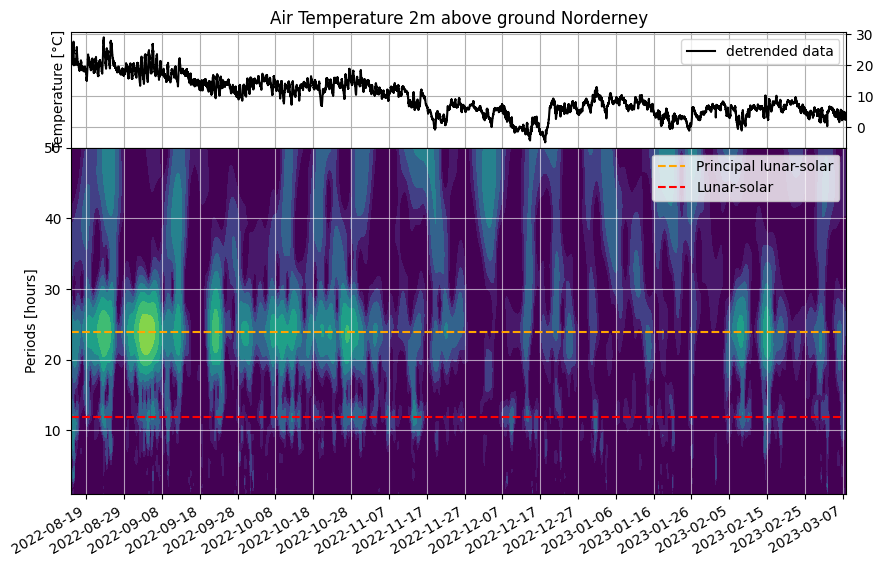

In [57]:
pyplot.close('all')
pyplot.ioff()

fig , axes = plt.subplots(2, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1,3]})

ax = axes[0]

ax.plot(weather_data_dated["MESS_DATUM"], dat, 'k', linewidth=1.5, label='detrended data')
#ax.set_ylim(-0.01, 0.015)
ax.legend()
ax.grid()
ax.yaxis.tick_right()
ax.set_ylabel(r"Temperature [°C]")
ax.set_title("Air Temperature 2m above ground Norderney")

bx = axes[1]

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

bx.contourf(weather_data_dated["MESS_DATUM"], period, np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
bx.set_ylim(1,50)
bx.set_xticks(days)
bx.set_xlim(np.datetime64('2022-08-15'))
bx.tick_params(axis ='x', labelrotation =30)
plt.xticks(ha='right')
bx.grid(color='white',alpha=0.6)
bx.set_ylabel("Periods [hours]")

bx.hlines(23.934, days[0], days[-1], color='orange', linestyles='dashed', label='Principal lunar-solar')
bx.hlines(11.967, days[0], days[-1], color='red', linestyles='dashed',    label='Lunar-solar')
bx.legend()
plt.show()

#fig.savefig("Output/Wavelet_weather_temperature.pdf", dpi=300)
fig.savefig("Output/Wavelet_weather_temperature.png", dpi=300)

In [40]:
#-------------------------------------
start_date = datetime.datetime(2022,8,10, tzinfo = pytz.timezone("Europe/Berlin"))
end_date = datetime.datetime(2023,3,8, tzinfo = pytz.timezone("Europe/Berlin"))

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 10)

weather_data_dated = data_merged[(data_merged["MESS_DATUM"]>=start_date) &  (data_merged["MESS_DATUM"]<=end_date)]
#--------------------------------------
dat = weather_data_dated["FF_10"].values
#--------------------------------------

dt = 10/60      # Sampling interval in hours
N = dat.size
t = np.arange(N)
dat_notrend = signal.detrend(dat)
std = np.std(dat_notrend)
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
#alpha, _, _ = wavelet.ar1(dat_notrend)  # Lag-1 autocorrelation for red noise
mother = wavelet.Morlet(6)
s0 = 6* dt  # Starting scale, in this case 24 *  dt  = 1 hour
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj   # Seven powers of two with dj sub-octaves

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power /= scales[:, None]
#signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
#                                         significance_level=0.95,
#                                         wavelet=mother)
#sig95 = np.ones([1, N]) * signif[:, None]
#sig95 = power / sig95

#glbl_power = power.mean(axis=1)
#dof = N - scales  # Correction for padding at edges
#glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                        significance_level=0.95, dof=dof,
#                                        wavelet=mother)


#sel = find((period >= 20) & (period < 50))
# We also calculate the scale average between 20 hours and 28 hours, and its significance level.
#Cdelta = mother.cdelta
#scale_avg = (scales * np.ones((N, 1))).transpose()
#scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
#scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
#scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
#                                             significance_level=0.95,
#                                             dof=[scales[sel[0]],
#                                                  scales[sel[-1]]],
#                                             wavelet=mother)

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2867018895.py:5: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2867018895.py:6: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



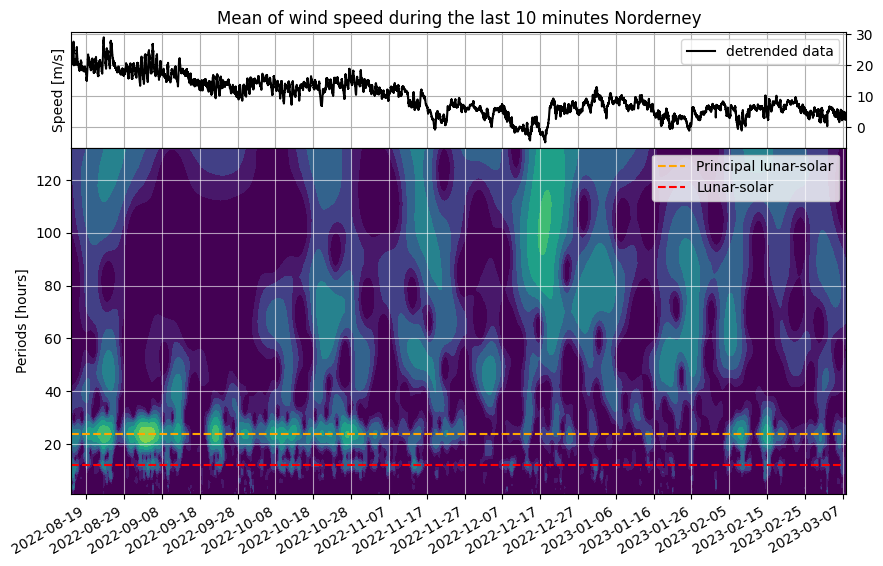

In [58]:
pyplot.close('all')
pyplot.ioff()

fig , axes = plt.subplots(2, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1,3]})

ax = axes[0]

ax.plot(weather_data_dated["MESS_DATUM"], dat, 'k', linewidth=1.5, label='detrended data')
#ax.set_ylim(-0.01, 0.015)
ax.legend()
ax.grid()
ax.yaxis.tick_right()
ax.set_ylabel(r"Speed [m/s]")
ax.set_title("Mean of wind speed during the last 10 minutes Norderney")

bx = axes[1]

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

bx.contourf(weather_data_dated["MESS_DATUM"], period, np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
#bx.set_ylim(1,50)
bx.set_xticks(days)
bx.set_xlim(np.datetime64('2022-08-15'))
bx.tick_params(axis ='x', labelrotation =30)
plt.xticks(ha='right')
bx.grid(color='white',alpha=0.6)
bx.set_ylabel("Periods [hours]")

bx.hlines(23.934, days[0], days[-1], color='orange', linestyles='dashed', label='Principal lunar-solar')
bx.hlines(11.967, days[0], days[-1], color='red', linestyles='dashed',    label='Lunar-solar')
bx.legend()
plt.show()

#fig.savefig("Output/Wavelet_weather_windspeed.pdf", dpi=300)
fig.savefig("Output/Wavelet_weather_windspeed.png", dpi=300)

para_labels = ["Langeoog","Spiekeroog","WangeroogeNord","WangeroogeWest"]
data_path = '../../../Data/2023_03_28_sealevels/'


for i in range(4):
    
    locals()[para_labels[i]] = pd.read_pickle(data_path+para_labels[i]+'.pkl')

Langeoog

In [42]:
para_labels = ["Langeoog","Spiekeroog","WangeroogeNord","WangeroogeWest"]
data_path = '../../../Data/2023_03_28_sealevels/'
directory_labels = ["Langeoog-W1.zrx","Spiekeroog-W1.zrx", "Wangerooge-Nord-W1.zrx", "Wangerooge-West-W1.zrx"]


for i in range(4):
    
    
    locals()[para_labels[i]] = pd.read_csv(data_path+directory_labels[i], skiprows=6, 
                                                      sep="\s+", parse_dates=[0], header=None)
    locals()[para_labels[i]][0] = pd.to_datetime(locals()[para_labels[i]][0], 
                                                           utc = pytz.timezone("Europe/Berlin"))
    locals()[para_labels[i]].rename(columns={0:"Date_Time", 1:"W_cm"}, inplace=True)
    
    locals()[para_labels[i]]['W_cm'] = pd.to_numeric(locals()[para_labels[i]]['W_cm'])
    
    locals()[para_labels[i]].sort_values('Date_Time', inplace=True)

In [43]:
Langeoog

Date_Time  W_cm
0      2022-10-01 00:01:00+00:00   530
1      2022-10-01 00:02:00+00:00   531
2      2022-10-01 00:03:00+00:00   531
3      2022-10-01 00:04:00+00:00   532
4      2022-10-01 00:05:00+00:00   532
...                          ...   ...
256315 2023-03-27 23:56:00+00:00   510
256316 2023-03-27 23:57:00+00:00   511
256317 2023-03-27 23:58:00+00:00   512
256318 2023-03-27 23:59:00+00:00   513
256319 2023-03-28 00:00:00+00:00   514

[256320 rows x 2 columns]

In [48]:
#-------------------------------------
start_date = datetime.datetime(2022,10,1, tzinfo = pytz.timezone("Europe/Berlin"))
end_date = datetime.datetime(2023,3,28, tzinfo = pytz.timezone("Europe/Berlin"))

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 10)

WangeroogeWest_dated = WangeroogeWest[(WangeroogeWest["Date_Time"]>=start_date) &  (WangeroogeWest["Date_Time"]<=end_date)]

#--------------------------------------
dat = WangeroogeWest_dated['W_cm'].values
#--------------------------------------

dt = 1/60      # Sampling interval in hours
N = dat.size
t = np.arange(N)
dat_notrend = signal.detrend(dat)
std = np.std(dat_notrend)
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
alpha, _, _ = wavelet.ar1(dat_notrend)  # Lag-1 autocorrelation for red noise
mother = wavelet.Morlet(6)
s0 = 60* dt  # Starting scale, in this case 24 *  dt  = 1 hour
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj   # Seven powers of two with dj sub-octaves

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)


sel = find((period >= 20) & (period < 50))
# We also calculate the scale average between 20 hours and 28 hours, and its significance level.
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2435758549.py:5: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\2435758549.py:6: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



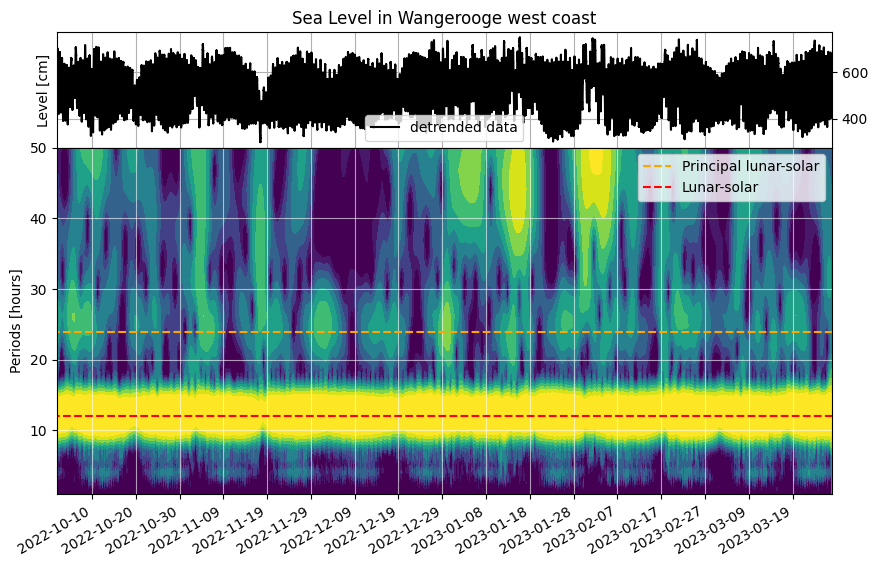

In [50]:
pyplot.close('all')
pyplot.ioff()

fig , axes = plt.subplots(2, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1,3]})

ax = axes[0]

ax.plot(WangeroogeWest_dated['Date_Time'], dat, 'k', linewidth=1.5, label='detrended data')

ax.legend()
ax.grid()
ax.yaxis.tick_right()
ax.set_ylabel(r"Level [cm]")
ax.set_title("Sea Level in Wangerooge west coast")

bx = axes[1]

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

bx.contourf(WangeroogeWest_dated['Date_Time'], period, np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
bx.set_ylim(1,50)
bx.set_xticks(days)
bx.set_xlim(np.datetime64('2022-10-02'))
bx.tick_params(axis ='x', labelrotation =30)
plt.xticks(ha='right')
bx.grid(color='white',alpha=0.6)
bx.set_ylabel("Periods [hours]")

bx.hlines(23.934, start_date, end_date, color='orange', linestyles='dashed', label='Principal lunar-solar')
bx.hlines(11.967, start_date, end_date, color='red', linestyles='dashed',    label='Lunar-solar')
bx.legend()
plt.show()

#fig.savefig("Output/Wavelet_sealevel_wangeroogew.pdf", dpi=300)
fig.savefig("Output/Wavelet_sealevel_wangeroogew.png", dpi=300)

In [59]:
#-------------------------------------
start_date = datetime.datetime(2022,10,1, tzinfo = pytz.timezone("Europe/Berlin"))
end_date = datetime.datetime(2023,3,28, tzinfo = pytz.timezone("Europe/Berlin"))

days = np.arange(np.datetime64(np.datetime_as_string(np.datetime64(start_date))[:10]),
         np.datetime64(np.datetime_as_string(np.datetime64(end_date+datetime.timedelta(days=1)))[:10]), 10)

soil_dated = soil[(soil["MESS_DATUM"]>=start_date) &  (soil["MESS_DATUM"]<=end_date)]

#--------------------------------------
dat = soil_dated['V_TE005'].values
#--------------------------------------

dt = 1      # Sampling interval in hours
N = dat.size
t = np.arange(N)
dat_notrend = signal.detrend(dat)
std = np.std(dat_notrend)
var = std ** 2  # Variance
dat_norm = dat_notrend / std  # Normalized dataset
#alpha, _, _ = wavelet.ar1(dat_notrend)  # Lag-1 autocorrelation for red noise
mother = wavelet.Morlet(6)
s0 = dt  # Starting scale, in this case  dt  = 1 hour
dj = 1 / 12  # Twelve sub-octaves per octaves
J = 7 / dj   # Seven powers of two with dj sub-octaves

wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)

iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

power /= scales[:, None]
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
#sig95 = np.ones([1, N]) * signif[:, None]
#sig95 = power / sig95

#glbl_power = power.mean(axis=1)
#dof = N - scales  # Correction for padding at edges
#glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
#                                        significance_level=0.95, dof=dof,
#                                        wavelet=mother)


#sel = find((period >= 20) & (period < 50))
# We also calculate the scale average between 20 hours and 28 hours, and its significance level.
#Cdelta = mother.cdelta
#scale_avg = (scales * np.ones((N, 1))).transpose()
#scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
#scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
#scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
#                                             significance_level=0.95,
#                                             dof=[scales[sel[0]],
#                                                  scales[sel[-1]]],
#                                             wavelet=mother)

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\1885197724.py:5: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future

C:\Users\Memo\AppData\Local\Temp\ipykernel_8968\1885197724.py:6: DeprecationWarning:

parsing timezone aware datetimes is deprecated; this will raise an error in the future



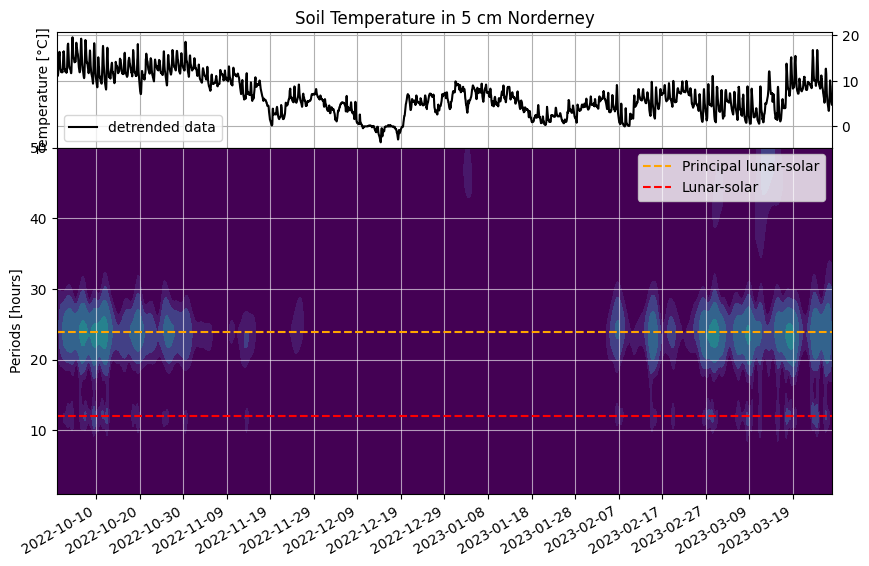

In [60]:
pyplot.close('all')
pyplot.ioff()

fig , axes = plt.subplots(2, figsize=(10,6), sharex=True, gridspec_kw={'hspace':0, 'height_ratios': [1,3]})

ax = axes[0]

ax.plot(soil_dated['MESS_DATUM'], dat, 'k', linewidth=1.5, label='detrended data')

ax.legend()
ax.grid()
ax.yaxis.tick_right()
ax.set_ylabel(r"Temperature [°C]]")
ax.set_title("Soil Temperature in 5 cm Norderney")

bx = axes[1]

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

bx.contourf(soil_dated['MESS_DATUM'], period, np.log2(power), np.log2(levels),
            extend='both', cmap=pyplot.cm.viridis)
bx.set_ylim(1,50)
bx.set_xticks(days)
bx.set_xlim(np.datetime64('2022-10-01'))
bx.tick_params(axis ='x', labelrotation =30)
plt.xticks(ha='right')
bx.grid(color='white',alpha=0.6)
bx.set_ylabel("Periods [hours]")

bx.hlines(23.934, start_date, end_date, color='orange', linestyles='dashed', label='Principal lunar-solar')
bx.hlines(11.967, start_date, end_date, color='red', linestyles='dashed',    label='Lunar-solar')
bx.legend()
plt.show()

#fig.savefig("Output/Wavelet_weather_soil.pdf", dpi=300)
fig.savefig("Output/Wavelet_weather_soil.png", dpi=300)